In [ ]:
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from utils import *

In [ ]:
X, Y = load_data()
X = X/255

(m, d) = X.shape
print(f'Input dimension:{d}, Total samples: {m}')

Input dimension:784, Total samples: 10000


In [ ]:
devScores = []
testScores = []
seeds = [28, 42, 84, 128, 164, 256, 512, 999]

for seed in tqdm(seeds):
    X_dev, X_test, Y_dev, Y_test = train_test_split(X, Y, test_size=.2, shuffle=True, stratify=Y, random_state=seed)
    
    sc = StandardScaler()
    # fit the scaler on dev set
    sc.fit(X_dev)
    # transform the dev set
    X_dev_sc = sc.transform(X_dev)
    # transform the test set
    X_test_sc = sc.transform(X_test)

    # euclidean knn
    knn_l2 = KNNClassifier()
    knn_l2.fit(data=X_dev_sc, labels=Y_dev)

    devScores.append(knn_l2.score(pMat=X_dev_sc, true=Y_dev, K=5, p=2))
    testScores.append(knn_l2.score(pMat=X_test_sc, true=Y_test, K=5, p=2))

100%|██████████| 8/8 [01:08<00:00,  8.56s/it]


In [ ]:
print(f'\n\nAverage accuracy on dev set: {np.mean(np.array(devScores)):.3f}')
print(f'Average accuracy on test set: {np.mean(np.array(testScores)):.3f}')



Average accuracy on dev set: 0.941
Average accuracy on test set: 0.913


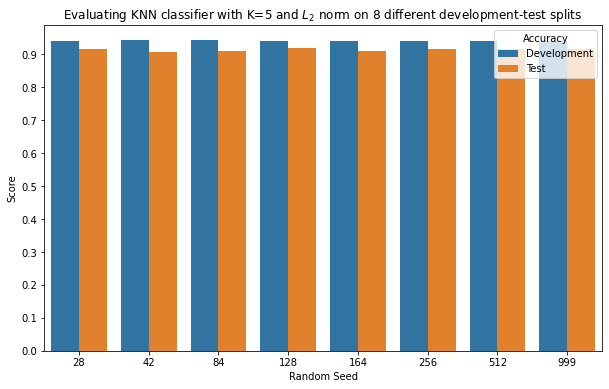

In [ ]:
df = {'Random Seed':seeds+seeds, 
      'Score':devScores+testScores, 
      'Accuracy':['Development']*8 + ['Test']*8}

df = pd.DataFrame(df)

plt.figure(figsize=(10,6))

sns.barplot(data=df, x='Random Seed', y='Score', hue='Accuracy')
plt.xlabel('Random Seed')
plt.ylabel('Average accuracy over 8 splits')
plt.yticks([.1*i for i in range(0, 10)])
plt.title('Evaluating KNN classifier with K=5 and $L_2$ norm')
plt.savefig('Evaluating_KNN_Classifer');

In [ ]:
devScores

[0.93925, 0.94275, 0.942125, 0.939875, 0.941625, 0.93875, 0.941, 0.939375]

In [ ]:
testScores

[0.915, 0.908, 0.9105, 0.9185, 0.91, 0.916, 0.915, 0.915]

Now, let us tune $K$ for $\ell2 \text{ norm}$ 

In [ ]:
nSplits = 10
maxNeighbors = 20
neighbors = [i+1 for i in range(maxNeighbors)]

X_dev, X_test, Y_dev, Y_test = train_test_split(X, Y, test_size=.2, shuffle=True, stratify=Y, random_state=42)
skf = StratifiedKFold(n_splits=nSplits, shuffle=True, random_state=84)

curr_split = 0
splitTrainScores = []
splitValScores = []

for train_index, val_index in skf.split(X_dev, Y_dev):
    curr_split += 1 

    X_train = X_dev[train_index]
    Y_train = Y_dev[train_index]

    X_val = X_dev[val_index]
    Y_val = Y_dev[val_index]

    sc = StandardScaler()
    # fit the scaler on train set
    sc.fit(X_train)
    # transform the train set
    X_train_sc = sc.transform(X_train)
    # transform the val set
    X_val_sc = sc.transform(X_val)

    # Build the KNN Classifier on train set
    knn_l2 = KNNClassifier()
    knn_l2.fit(data=X_train_sc, labels=Y_train)

    train_scores = []
    val_scores = []

    print(f'\n\nProcessing split:{curr_split}')
    for k in tqdm(neighbors):
        train_scores.append(knn_l2.score(pMat=X_train_sc, true=Y_train, K=k, p=2)) 
        val_scores.append(knn_l2.score(pMat=X_val_sc, true=Y_val, K=k, p=2))
   
    splitTrainScores.append(train_scores)
    splitValScores.append(val_scores)

splitTrainScores = np.array(splitTrainScores).T
splitValScores = np.array(splitValScores).T

avgTrainScores = np.mean(splitTrainScores, axis=1)
avgValScores = np.mean(splitValScores, axis=1)



Processing split:1


100%|██████████| 20/20 [01:57<00:00,  5.86s/it]




Processing split:2


100%|██████████| 20/20 [01:56<00:00,  5.82s/it]




Processing split:3


100%|██████████| 20/20 [01:55<00:00,  5.79s/it]




Processing split:4


100%|██████████| 20/20 [01:54<00:00,  5.72s/it]




Processing split:5


100%|██████████| 20/20 [01:55<00:00,  5.80s/it]




Processing split:6


100%|██████████| 20/20 [01:55<00:00,  5.76s/it]




Processing split:7


100%|██████████| 20/20 [01:54<00:00,  5.73s/it]




Processing split:8


100%|██████████| 20/20 [01:53<00:00,  5.69s/it]




Processing split:9


100%|██████████| 20/20 [01:53<00:00,  5.67s/it]




Processing split:10


100%|██████████| 20/20 [01:53<00:00,  5.67s/it]


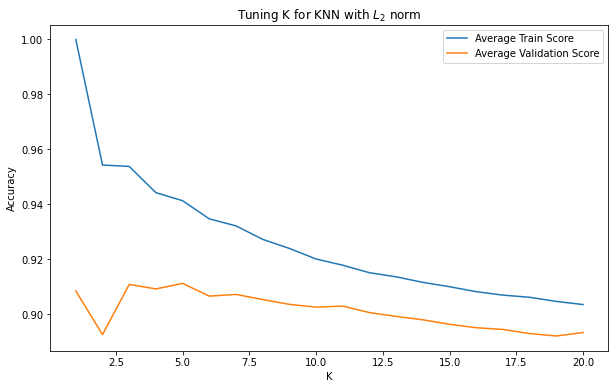

In [ ]:
plt.figure(figsize=(10,6))

sns.lineplot(x=neighbors, y=avgTrainScores, label='Average Train Score')
sns.lineplot(x=neighbors, y=avgValScores, label='Average Validation Score')

plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Tuning K for KNN with $L_2$ norm')
plt.legend()
plt.savefig('Tuning K');

We can see that $K=5$ seems to be the sweet spot. Now let us evaluate our model with $K=5$ on the test dataset.

In [ ]:
knn_l2 = KNNClassifier()

sc = StandardScaler()
# fit the scaler on dev set
sc.fit(X_dev)
# transform the dev set
X_dev_sc = sc.transform(X_dev)
# transform the test set
X_test_sc = sc.transform(X_test)

# trained the tuned model on whole development set
knn_l2.fit(data=X_dev_sc, labels=Y_dev)

print(f'\nAccuracy on development set: {knn_l2.score(pMat=X_dev_sc, true=Y_dev, K=5, p=2):.3f}\n')
print(f'Accuracy on test set: {knn_l2.score(pMat=X_test_sc, true=Y_test, K=5, p=2):.3f}')



Accuracy on development set: 0.943

Accuracy on test set: 0.908


We will use $K=5$ to perform comparative analysis between MLE Classifier and KNN